In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version = "v2")

In [4]:
# Set the tickers for both the bond and stock portion of the portfolio
#SPY = S&P500
#AGG= Core US Aggregate Bond ETF
#QQQ= QQQ tracks a modified-market-cap-weighted index of 100 NASDAQ-listed stocks.
#VTV= Value ETF (Provides a convenient way to match the performance of many of the nation’s largest value stocks), 
#IEMG = Emerging Market ETF
#IWM = Russell 2000 index ETF (small cap)
tickers = ['SPY', 'AGG', 'QQQ','VTV', 'IEMG', 'IWM']

# Set timeframe to 1D 
timeframe = "1Day"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2017-01-01T00:00:00", tz = "America/Los_Angeles").isoformat()
end_date = pd.Timestamp("2021-12-31T00:00:00", tz = "America/Los_Angeles").isoformat()
limit_rows = 10000



In [5]:
#function that accepts a variable string ticker for pulling the dataframe from alpaca
def puller(ticker):
    df1 = alpaca.get_bars(ticker, 
                          timeframe, 
                          start=start_date, 
                          end=end_date, 
                          limit=limit_rows).df
    return df1

#function for structuring dataframe so MCsimulation will accept as input
def structuredata(df, ticker):    
    col_names = [(ticker, x) for x in df.columns]
    df.columns = pd.MultiIndex.from_tuples(col_names)
    return df

#function to merge two dfs into MCsimulation format
def merger(df1, df2):
        df_merged = pd.merge(df1, df2, how = "inner", left_index=True, right_index=True)
        return df_merged

#run function that accepts a list of strings and other defined other variables needed for structuring the combined data
def run(list, currentdf, ticker):
        if(list.index(ticker) == 0):
                df = puller(ticker)
                df = structuredata(df, ticker)
                #display(df.head())
                #print('hi')
                return df
        else:        
                df = puller(ticker)
                df = structuredata(df, ticker)
                df = merger(currentdf, df)
                #display(df.head())
                #print('ho')
                return df

MCdf = pd.DataFrame()

for i in tickers:
        MCdf = run(tickers, MCdf, i)

display(MCdf.head())


SPY                                        \
                             open      high       low   close    volume   
timestamp                                                                 
2017-01-03 05:00:00+00:00  225.07  225.8300  223.8837  225.24  91366522   
2017-01-04 05:00:00+00:00  225.64  226.7500  225.6100  226.58  78744433   
2017-01-05 05:00:00+00:00  226.28  226.5800  225.4800  226.40  78379012   
2017-01-06 05:00:00+00:00  226.53  227.7500  225.9000  227.21  71559922   
2017-01-09 05:00:00+00:00  226.90  227.0701  226.4163  226.46  46939676   

                                                      AGG                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2017-01-03 05:00:00+00:00      314573  224.642686  107.73  108.22  107.7300   
2017-01-04 05:00:00+00:00      259503  226.196593  108.16  108.21  108.0300   
2017-01-05 05:00:00+00:00      218284  226.251697  108.37  108.68  108.2201   
2017-01-06 05:00:00+00:00      235983  227.113087  108.43  108.50  108.2600   
2017-01-09 05:00:00+00:00      158755  226.731966  108.54  108.54  108.4300   

                           ...     IEMG                            IWM  \
                           ...   volume trade_count       vwap    open   
timestamp                  ...                                           
2017-01-03 05:00:00+00:00  ...  7008609       21534  42.880855  136.52   
2017-01-04 05:00:00+00:00  ...  5154644       22121  43.244844  136.05   
2017-01-05 05:00:00+00:00  ...  5440393       16873  43.720961  137.50   
2017-01-06 05:00:00+00:00  ...  7137810       27035  43.561160  136.41   
2017-01-09 05:00:00+00:00  ...  4767580       17904  43.551103  135.54   

                                                                           \
                               high     low   close    volume trade_count   
timestamp                                                                   
2017-01-03 05:00:00+00:00  136.8295  134.50  135.52  29792446      125905   
2017-01-04 05:00:00+00:00  137.9600  136.01  137.78  34499365      139192   
2017-01-05 05:00:00+00:00  137.7600  135.51  136.19  30286876      123714   
2017-01-06 05:00:00+00:00  136.7100  135.68  135.69  23435995       97449   
2017-01-09 05:00:00+00:00  135.7200  134.50  134.80  24013865       99844   

                                       
                                 vwap  
timestamp                              
2017-01-03 05:00:00+00:00  135.469157  
2017-01-04 05:00:00+00:00  137.292887  
2017-01-05 05:00:00+00:00  136.444733  
2017-01-06 05:00:00+00:00  136.110436  
2017-01-09 05:00:00+00:00  135.105597  

[5 rows x 42 columns]

In [11]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights can be split in any fashion between tickers ['SPY', 'AGG', 'QQQ','VTV', 'IEMG', 'IWM']
# Run 500 samples.
MC_equal_weight = MCSimulation(
    portfolio_data = MCdf,
    weights = [.4, .2, .1, .1, .1, .1],
    num_simulation = 500,
    num_trading_days = 252*15
)

# Review the simulation input data
# Printing the first five rows of the simulation input data
MC_equal_weight.portfolio_data.head()

SPY                                        \
                             open      high       low   close    volume   
timestamp                                                                 
2017-01-03 05:00:00+00:00  225.07  225.8300  223.8837  225.24  91366522   
2017-01-04 05:00:00+00:00  225.64  226.7500  225.6100  226.58  78744433   
2017-01-05 05:00:00+00:00  226.28  226.5800  225.4800  226.40  78379012   
2017-01-06 05:00:00+00:00  226.53  227.7500  225.9000  227.21  71559922   
2017-01-09 05:00:00+00:00  226.90  227.0701  226.4163  226.46  46939676   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-01-03 05:00:00+00:00      314573  224.642686          NaN  107.73   
2017-01-04 05:00:00+00:00      259503  226.196593     0.005949  108.16   
2017-01-05 05:00:00+00:00      218284  226.251697    -0.000794  108.37   
2017-01-06 05:00:00+00:00      235983  227.113087     0.003578  108.43   
2017-01-09 05:00:00+00:00      158755  226.731966    -0.003301  108.54   

                                   ...       IEMG                  IWM  \
                             high  ...       vwap daily_return    open   
timestamp                          ...                                   
2017-01-03 05:00:00+00:00  108.22  ...  42.880855          NaN  136.52   
2017-01-04 05:00:00+00:00  108.21  ...  43.244844     0.008856  136.05   
2017-01-05 05:00:00+00:00  108.68  ...  43.720961     0.011550  137.50   
2017-01-06 05:00:00+00:00  108.50  ...  43.561160    -0.004567  136.41   
2017-01-09 05:00:00+00:00  108.54  ...  43.551103    -0.002294  135.54   

                                                                           \
                               high     low   close    volume trade_count   
timestamp                                                                   
2017-01-03 05:00:00+00:00  136.8295  134.50  135.52  29792446      125905   
2017-01-04 05:00:00+00:00  137.9600  136.01  137.78  34499365      139192   
2017-01-05 05:00:00+00:00  137.7600  135.51  136.19  30286876      123714   
2017-01-06 05:00:00+00:00  136.7100  135.68  135.69  23435995       97449   
2017-01-09 05:00:00+00:00  135.7200  134.50  134.80  24013865       99844   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-01-03 05:00:00+00:00  135.469157          NaN  
2017-01-04 05:00:00+00:00  137.292887     0.016677  
2017-01-05 05:00:00+00:00  136.444733    -0.011540  
2017-01-06 05:00:00+00:00  136.110436    -0.003671  
2017-01-09 05:00:00+00:00  135.105597    -0.006559  

[5 rows x 48 columns]

In [12]:
MC_equal_weight.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\gitrepo\Project-1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000454,0.999689,1.000280,1.005243,1.009510,1.003236,1.007843,0.993034,1.004024,0.999650,...,1.001371,1.004559,0.997587,1.006892,0.996961,0.994888,1.006853,0.999012,1.003220,1.000148
2,1.014299,0.997649,1.001686,0.995908,1.014647,1.003558,1.016499,0.993809,1.012616,0.985892,...,1.003889,1.006437,0.994415,1.004595,0.991176,0.997013,1.000349,1.001696,1.008049,1.006027
3,1.007833,0.997508,0.999675,0.988089,1.020777,1.001909,1.021980,0.999225,1.010855,0.980770,...,1.002439,1.007554,0.991940,1.000661,1.000473,0.989552,0.998304,1.002844,1.005126,1.001556
4,1.001472,0.983291,1.002919,0.988745,1.026966,0.998691,1.020447,0.987715,1.012137,0.979174,...,1.014186,1.008462,0.997692,0.989865,0.996592,0.989466,0.996131,1.007781,0.999066,1.003130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,9.582580,4.872503,4.026304,7.132390,9.049243,5.217735,4.623635,7.876500,4.323508,4.679712,...,4.518935,6.409395,6.818854,5.091073,4.180980,5.931347,3.469856,3.404506,10.933276,3.661256
3777,9.608419,4.875926,4.029926,7.166214,9.012134,5.191110,4.629536,7.895009,4.327912,4.681189,...,4.515977,6.465080,6.808552,5.119705,4.185360,5.840296,3.473575,3.437444,10.951928,3.668631
3778,9.676027,4.908538,4.026912,7.051245,9.039430,5.198334,4.618459,7.894453,4.304043,4.731123,...,4.521480,6.415257,6.781752,5.171268,4.164035,5.824978,3.454164,3.450009,10.878476,3.646379
3779,9.656840,4.933952,4.083163,7.045369,9.123834,5.193452,4.648879,7.943262,4.350639,4.783500,...,4.504911,6.399466,6.800030,5.145535,4.171453,5.803883,3.461310,3.490490,10.882743,3.642461


count           500.000000
mean              6.622267
std               2.319590
min               2.410756
25%               4.959231
50%               6.187289
75%               7.965954
max              16.786017
95% CI Lower      3.253924
95% CI Upper     12.540549
Name: 3780, dtype: float64


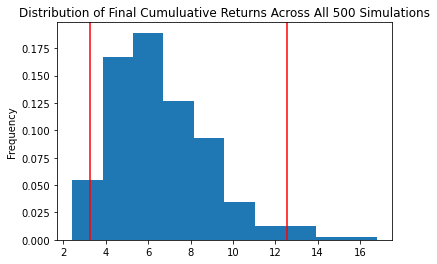

In [13]:
#MC_equal_weight_plot = MC_equal_weight.plot_simulation()
MC_equal_weight_dist = MC_equal_weight.plot_distribution()
MC_summary_stats = MC_equal_weight.summarize_cumulative_return()
print(MC_summary_stats)

In [15]:
# Using the lower and upper `95%` confidence intervals from the summary statistics,
# calculate the range of the probable cumulative returns for a $500000 investment
ci_95_lower_cumulative_return = MC_summary_stats[8] * 500000
ci_95_upper_cumulative_return = MC_summary_stats[9] * 500000

print(f"There is a 95% chance that an initial investment of $500,000 in the portfolio"
    f" over the next 15 years will end within in the range of"
    f" ${ci_95_lower_cumulative_return: .2f} and ${ci_95_upper_cumulative_return: .2f}.")

There is a 95% chance that an initial investment of $500,000 in the portfolio over the next 15 years will end within in the range of $ 1626961.92 and $ 6270274.26.


In [10]:
"""
Although this result presents potentially fantastic news, it’s important to note that these five-year forecasted return values are based on only three years of historical price data. The five-year forecast simulates more variability than the data that the simulation is based on includes. In general, it’s ideal to supply one year of historical data for each year of simulated data.

If we simulate using only small amounts of data during a recent time when markets are booming, or instead falling precipitously, a Monte-Carlo Analysis will inadvertently extrapolate this temporary market movement too far into the future. Getting data over a longer time period mitigates this effect. Due to the limitations of the Alpaca API, however, we can typically produce just three full years of historical data.
"""

'\nAlthough this result presents potentially fantastic news, it’s important to note that these five-year forecasted return values are based on only three years of historical price data. The five-year forecast simulates more variability than the data that the simulation is based on includes. In general, it’s ideal to supply one year of historical data for each year of simulated data.\n\nIf we simulate using only small amounts of data during a recent time when markets are booming, or instead falling precipitously, a Monte-Carlo Analysis will inadvertently extrapolate this temporary market movement too far into the future. Getting data over a longer time period mitigates this effect. Due to the limitations of the Alpaca API, however, we can typically produce just three full years of historical data.\n'